In [1]:
import warnings
warnings.filterwarnings('ignore')

import os.path
import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion
from sklearn.feature_extraction.text import TfidfVectorizer


conn = sqlite3.connect('keyword_based_database.db')

q='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%ford%'
AND LOWER(tweet_text) NOT LIKE '%harrison%'  
AND LOWER(tweet_text) NOT LIKE '%doug%'
AND LOWER(tweet_text) NOT LIKE '%government%'
AND LOWER(tweet_text) NOT LIKE '%goverment%'
AND LOWER(tweet_text) NOT LIKE '%tax%'
AND LOWER(tweet_text) NOT LIKE '%toronto%'
LIMIT 10000;
'''

q2='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%@toyota%'  
LIMIT 10000;
'''

df = pd.read_sql_query(q2,conn)

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---------------------------------------------------------
Column names: 
 ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The number of tweets:  1978 

---------------------------------------------------------
0    RT @johnoft: @ToyotaGB @The_PlugSeeker I think...
1    @ToyotaSA Don’t look at past wins! Like Toyota...
2    @ToyotaSA There is only man machine and Toyota...
3    @Toyota @SoutheastToyota Recall the 2018 Camry...
4    RT @MattWeaverAW: On Oct. 31, @KeithKunz, @Mil...
5    RT @Toyota: You'll have to get used to the ext...
6    RT @ToyotaSouthBay: Summer adventures are what...
7    @Toyota @SoutheastToyota also how do I add @Ap...
8    @RoboRecruiter_ @SalesforceTower @jumpbikes @s...
9    RT @ScootNetworks: @RoboRecruiter_ @Salesforce...
Name: tweet_text, dtype: object


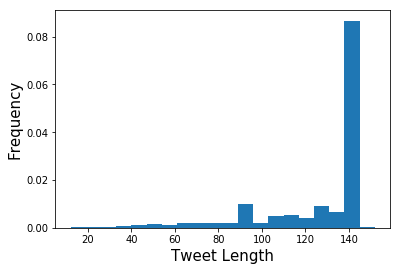

In [2]:
# Some simple Data exploration

N_raw_tweets = len(df)

print('---------------------------------------------------------')
print('Column names: \n', list(df.columns.values),"\n")
print('The number of tweets: ', N_raw_tweets,'\n')
print('---------------------------------------------------------')

# Show the First ten items in the tweet database
print(df['tweet_text'][0:10])



# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_raw.pdf',bboxes='tight')
plt.show()



The number of tweets after removing duplicates:  982 

Fraction removed:  0.504


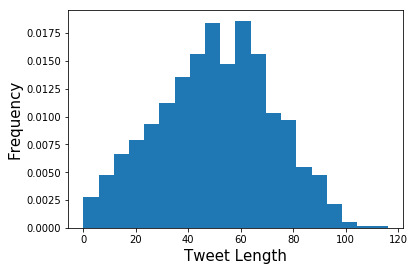

In [3]:
# Apply the 'Clean-up-text function to all tweets in the data frame'
df['tweet_text'] = df['tweet_text'].apply(clean_up_text)


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)

N_processed_tweets = len(df)

print('\n')
print('=============================================================')
print('The number of tweets after removing duplicates: ', N_processed_tweets ,'\n')
print('Fraction removed: ', round(1.0-(N_processed_tweets/float(N_raw_tweets)),3) )
print('=============================================================')

# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_processed.pdf',bboxes='tight')
plt.show()

In [4]:
import warnings
warnings.filterwarnings('ignore')

from process_text import clean_up_text
from process_text import string_cohesion
from textblob import TextBlob
import spacy
import pickle
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

#--------------------------------------------------------------
# Import the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
#--------------------------------------------------------------


#--------------------------------------------------------------
# Import the vocabulary and generate the vectorizer tranformer
#--------------------------------------------------------------
(A,terms,dict_sample) = joblib.load( "/home/javier/Documents/sentiment_analysis/sentiment_model/articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
print('number of terms: ',len(terms))#print(dic_sample[0:10])
print('Dictionary: ',len(dict_sample))

vectorizer = TfidfVectorizer(stop_words = custom_stop_words,min_df = 20)
A = vectorizer.fit_transform(dict_sample)
print('A: ', A.shape)
#--------------------------------------------------------------


#--------------------------------------------------------------
# We load the trained models
#--------------------------------------------------------------
# The names of the files containing the weights of the model
filename1 = 'lr_sentiment_model.sav'
filename2 = 'nb_sentiment_model.sav'

# Now we load in the trained models
loaded_lr = pickle.load(open(filename1, 'rb'))
loaded_nb = pickle.load(open(filename2, 'rb'))




#sample_text = df['tweet_text'][23]
#sample_text = 'I had a decent time with this vehicle, recommend'
#sample_text = 'I had a decent time with this vehicle, so I would recommend it'
sample_text = 'such a bad car #BMW'

s = str(clean_up_text(sample_text))

# Transform the text
X0 = vectorizer.transform([s])

# Predict the class 
preds_nb = loaded_nb.predict(X0)
preds_lr = loaded_lr.predict(X0)
preds_blob =  TextBlob(sample_text).sentiment.polarity
if(preds_blob>=0.0):
    preds_blob = +1
else:
    preds_blob = -1



# Compute the probability of the class
indx_nb= int((preds_nb[0]+1)/2)
indx_lr= int((preds_lr[0]+1)/2)
prob_nb = abs((loaded_nb.predict_proba(X0)[0][indx_nb]-.50)*2.0*int(preds_nb[0]))
prob_lr = abs((loaded_lr.predict_proba(X0)[0][indx_lr]-0.50)*2.0*int(preds_lr[0]))
prob_blob = abs(TextBlob(sample_text).sentiment.polarity) # [-1,1]

print(indx_nb)
print(s)
print(sample_text,[preds_nb[0],preds_lr[0],preds_blob],[prob_nb,prob_lr,prob_blob ] )

Loaded 2442 X 1963 document-term matrix
number of terms:  1963
Dictionary:  6105
A:  (6105, 1963)
0
bad car bmw
such a bad car #BMW [-1, -1, -1] [0.3580657920989281, 0.37478204239024215, 0.3499999999999999]


In [5]:
threshold = 0.2
sentiment_pred = []
sentiment_prob = []

for k in range(0,len(df)):
    
    sample_text = df['tweet_text'][k]
    s = str(clean_up_text(sample_text))

    # Transform the text
    X0 = vectorizer.transform([s])

    # Predict the class 
    preds_nb = loaded_nb.predict(X0)
    preds_lr = loaded_lr.predict(X0)
    preds_blob =  TextBlob(sample_text).sentiment.polarity
    
    if(preds_blob>=0.0):
        preds_blob = +1
    else:
        preds_blob = -1

    # Compute the probability of the class
    indx_nb= int((preds_nb[0]+1)/2)
    indx_lr= int((preds_lr[0]+1)/2)
    prob_nb = abs((loaded_nb.predict_proba(X0)[0][indx_nb]-.50)*2.0*int(preds_nb[0]))
    prob_lr = abs((loaded_lr.predict_proba(X0)[0][indx_lr]-0.50)*2.0*int(preds_lr[0]))
    prob_blob = abs(TextBlob(sample_text).sentiment.polarity) # [-1,1]
    
    if(prob_lr<threshold):
        preds_lr=[0.0]
        
    if(prob_nb<threshold):
        preds_nb=[0.0]
        
    if(prob_blob<threshold):
        preds_blob =0.0
    
    
    #model_predict = [m1_p,m2_p,m3_p]
    
    sentiment_pred.append([preds_nb[0],preds_lr[0],preds_blob])
    sentiment_prob.append([prob_nb,prob_lr,prob_blob ])
    #print(indx_nb)
    #print(sample_text,[preds_nb[0],preds_lr[0],preds_blob],[prob_nb,prob_lr,prob_blob ] )

In [6]:
y_model1 =[ sentiment_pred[k][0] for k in range(len(sentiment_pred))]
y_model2 =[ sentiment_pred[k][1] for k in range(len(sentiment_pred))]
y_model3 =[ sentiment_pred[k][2] for k in range(len(sentiment_pred))]

y_model1_prob =[ sentiment_prob[k][0] for k in range(len(sentiment_prob))]
y_model2_prob =[ sentiment_prob[k][1] for k in range(len(sentiment_prob))]
y_model3_prob =[ sentiment_prob[k][2] for k in range(len(sentiment_prob))]

982


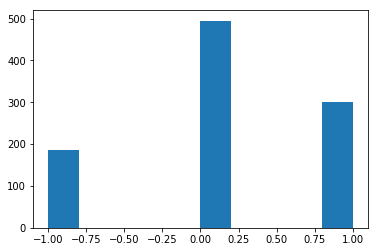

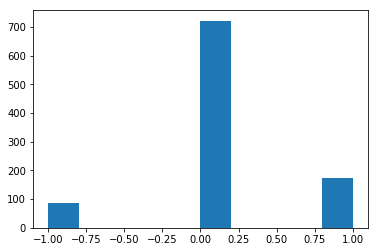

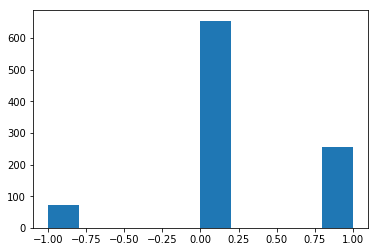

In [7]:
print(len(y_model1))
plt.hist(y_model1)
plt.show()

plt.hist(y_model2)
plt.show()

plt.hist(y_model3)
plt.show()

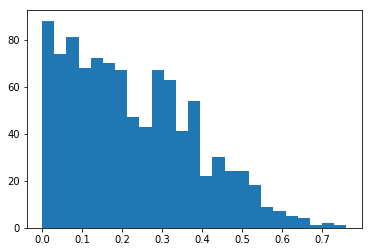

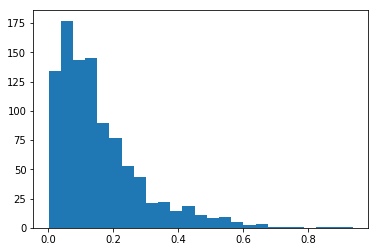

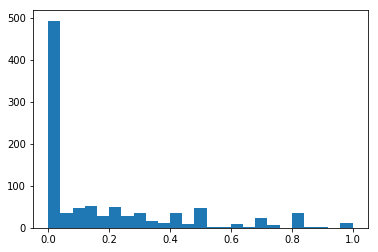

In [8]:
plt.hist(y_model1_prob,bins=25)
plt.show()

plt.hist(y_model2_prob,bins=25)
plt.show()

plt.hist(y_model3_prob,bins=25)
plt.show()

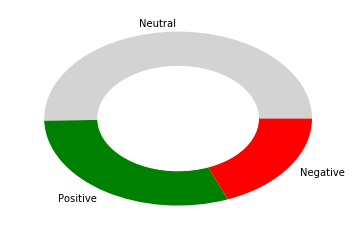

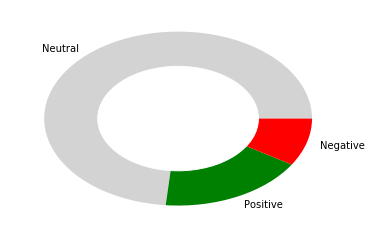

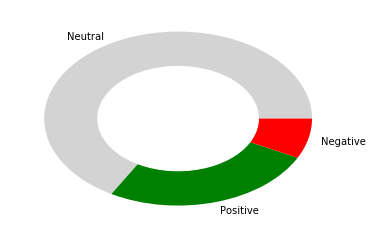

In [9]:
import matplotlib.pyplot as plt
import collections, numpy

# create data
names='Neutral', 'Positive', 'Negative'

m1_count= collections.Counter(y_model1)
m2_count= collections.Counter(y_model2)
m3_count= collections.Counter(y_model3)


size_model1=[m1_count[0],m1_count[1],m1_count[-1]]
size_model2=[m2_count[0],m2_count[1],m2_count[-1]]
size_model3=[m3_count[0],m3_count[1],m3_count[-1]]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.6, color='white')


# Give color names
plt.pie(size_model1, labels=names, colors=['lightgrey','green','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.pie(size_model2, labels=names, colors=['lightgrey','green','red'])
plt.show()


my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.pie(size_model3, labels=names, colors=['lightgrey','green','red'])
plt.show()

